# Distributed Applications
## Project 1: Cloud-based Deployment and Testing

### Group 21:
- Bernardo Maria Avides Moreira Amorim Alves (bernardomaria.avidesmoreiraamorimalv@student.kuleuven.be)
- Alken Rrokaj	(alken.rrokaj@student.kuleuven.be)
- Lennart Steenberghs	(lennart.steenberghs@student.kuleuven.be)
- Michiel Thiers (michiel.thiers@student.kuleuven.be)

In [43]:
# clear all values
%reset -f

In [44]:
import os
import numpy as np
import requests
import time
import concurrent.futures
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pickle

## Definition of the functions

### Test functions

In [45]:

def parse_soap_elements(xml_str):
    root = ET.fromstring(xml_str)
    element_dict = {element.tag.split('}')[1]: element.text for element in root.iter() if '}' in element.tag}
    identifier = list(element_dict.keys())[-1]
    return identifier, element_dict[identifier]

def send_rest(url, method, payload=None):
    try:
        if method == "GET":
            response = requests.get(url)
        elif method == "POST":
            response = requests.post(url, json=payload)
        elif method == "PUT":
            response = requests.put(url, json=payload)
        elif method == "DELETE":
            response = requests.delete(url)
        else:
            raise ValueError(f"Invalid method {method}")
    except:
        print(f"Request failed: {url}")
        return None
    return response

def send_soap(url, data):
    headers = {
        'Content-Type': 'text/xml',
        'SOAPAction': '',
    }
    response = requests.post(url, data=data, headers=headers)
    return response

def concurrent_test(dns, port, request_list, num_requests, req='REST'):
    # print server name
    server = f"http://{dns}:{port}"
    country = server.split('.')[1]
    print(f"Server: {country}")
    
    # test every request
    response_times_dict = {}
    for request in request_list: 
        # parse request
        url, method, *args = request
        if req == 'SOAP':
            identifier = parse_soap_elements(method)[0]
        elif req == 'REST':
            identifier = url
        payload = args[0] if args else None
        
        # send requests concurrently
        response_times = []
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for i in range(num_requests):
                # start timer
                start_time = time.perf_counter()
                # send request
                if req == 'REST': send_rest(server + url, method, payload)
                elif req == 'SOAP': send_soap(server + url, payload)
                # end timer
                end_time = time.perf_counter()
                # calculate response time
                response_time = end_time - start_time
                # add response time to list
                response_times.append(response_time)
            # total time rounded to 3 decimal places
            total_time = round(sum(response_times), 3)
            
            if identifier in response_times_dict:
                response_times_dict[identifier] += total_time
            else:
                response_times_dict[identifier] = total_time
            if req == 'REST': 
                print(f"URL: {url}, Method: {method}, Total Response Time: {total_time}")
            elif req == 'SOAP':
                print(f"URL: {identifier}, Method: {parse_soap_elements(method)}, Total Response Time: {total_time}")
    return response_times_dict

### Other Functions

In [46]:
def plot_data(data,num_requests, this_ip, server_list, title='Response Time by API Endpoint and Server', ylabel='Response Time (s)', extra_title=None):
    # add the number of tirals to the extra title   
    extra_title = f"{num_requests} Trials"

    # if this server is in the list, add the location to the extra title
    location = None
    for dns, ip in server_list:
        if this_ip in ip:
            extra_title += f" - {dns.split('.')[1]}"
    if location is None:
        extra_title += f" - Leuven"

    # extract the server names and API endpoints
    servers = list(data[list(data.keys())[0]].keys())
    endpoints = list(data.keys())

    # create an array of the data
    values = np.zeros((len(endpoints), len(servers)))
    for i, endpoint in enumerate(endpoints):
        for j, server in enumerate(servers):
            values[i, j] = data[endpoint][server]

    # plot the data
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    opacity = 0.8
    index = np.arange(len(endpoints))
    for i, server in enumerate(servers):
        country = server.split('.')[1]
        ax.bar(index + i * bar_width, values[:, i], bar_width, alpha=opacity, label=country )

    full_title = title
    if extra_title is not None:
        full_title = f"{title} - {extra_title}"

    ax.set_xlabel('API Endpoints')
    ax.set_ylabel(ylabel)
    ax.set_title(full_title)
    ax.set_xticks(index + bar_width * (len(servers) - 1) / 2)
    ax.set_xticklabels(endpoints)
    ax.legend()

    plt.tight_layout()
    plt.show()

    return fig, ax

# to save the variables (server)
def save_dict_as_pickle_file(dictionary, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dictionary, f)

# to load the variables
def load_dict_from_pickle_file(filename):
    with open(filename, 'rb') as f:
        dictionary = pickle.load(f)
    return dictionary

## Global Variables

In [47]:
server_list = [
    ('alnike.japaneast.cloudapp.azure.com', '20.210.110.130'),
    ('uswest-thiers.westus3.cloudapp.azure.com', '20.106.100.68'),
    ('useast-lennart.eastus2.cloudapp.azure.com', '20.1.139.66'), 
    ('dapps.westeurope.cloudapp.azure.com', '98.71.185.120')
]

num_requests = 1
this_ip = requests.get('https://api.ipify.org').text

## Run the REST requests

In [48]:
rest_port = 8081
rest_request_list = [
    ['/rest/order', 'POST', {'address': '123 Main St', 'meals': ['Fish and Chips', 'Steak']}],
    ['/rest/meals', 'GET'],
    ['/rest/largest-meal', 'GET'],
    ['/rest/cheapest-meal', 'GET']
]

rest_response_times_dict = {}

for dns, ip in server_list:
    # if this is the current server, skip
    if ip == this_ip: continue

    # test REST
    response_times = concurrent_test(dns, rest_port, rest_request_list, num_requests, req='REST')
    
    for url, times in response_times.items():
        if url not in rest_response_times_dict:
            rest_response_times_dict[url] = {}
        rest_response_times_dict[url][dns] = times
    print('\n')

Server: japaneast
URL: /rest/order, Method: POST, Total Response Time: 0.731
URL: /rest/meals, Method: GET, Total Response Time: 0.679
URL: /rest/largest-meal, Method: GET, Total Response Time: 0.536
URL: /rest/cheapest-meal, Method: GET, Total Response Time: 0.453


Server: westus3
URL: /rest/order, Method: POST, Total Response Time: 0.317
URL: /rest/meals, Method: GET, Total Response Time: 0.389
URL: /rest/largest-meal, Method: GET, Total Response Time: 0.345
URL: /rest/cheapest-meal, Method: GET, Total Response Time: 0.311


Server: eastus2
Request failed: http://useast-lennart.eastus2.cloudapp.azure.com:8081/rest/order
URL: /rest/order, Method: POST, Total Response Time: 0.267
Request failed: http://useast-lennart.eastus2.cloudapp.azure.com:8081/rest/meals
URL: /rest/meals, Method: GET, Total Response Time: 0.101
Request failed: http://useast-lennart.eastus2.cloudapp.azure.com:8081/rest/largest-meal
URL: /rest/largest-meal, Method: GET, Total Response Time: 0.14
Request failed: htt

## Plotting the Time Response for the REST requests

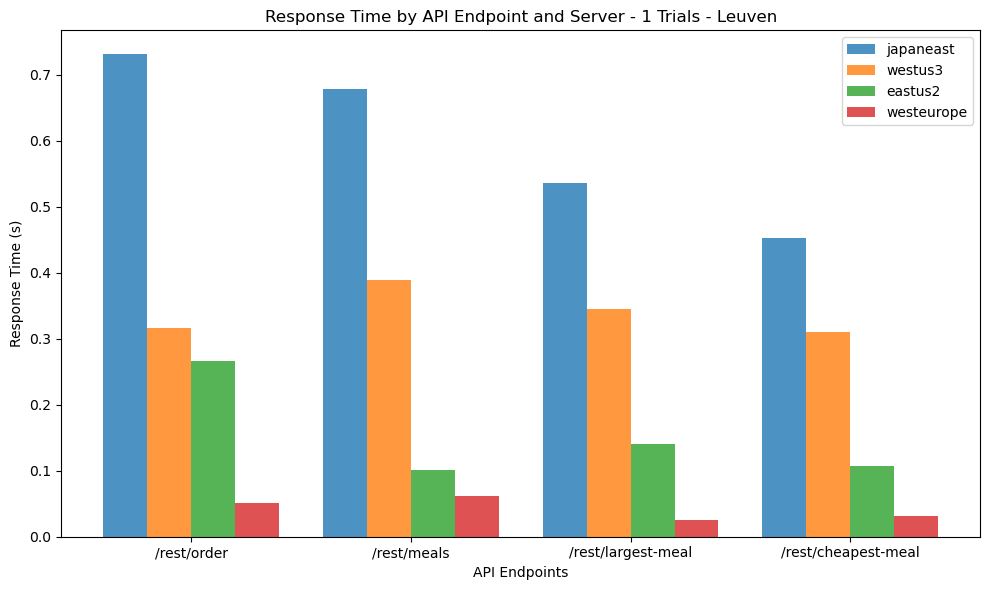

In [49]:
plot_data(rest_response_times_dict, num_requests, this_ip, server_list, extra_title=None);

## Run the SOAP requests

In [50]:
# read the soap requests from the directory
soap_request_list = []
soap_dir = 'soap_requests'
for filename in os.listdir(soap_dir):
    with open(os.path.join(soap_dir, filename), 'r') as f:
        data = f.read()
        soap_request_list.append(['/ws', data.strip()])

soap_port = 8082

# call concurrent_test() with soap_request_list
soap_response_times_dict = {}
for dns, ip in server_list:
    # if this is the current server, skip
    if ip == this_ip: continue

    # test REST or SOAP
    response_times = concurrent_test(dns, soap_port, soap_request_list, num_requests, req='SOAP')
    
    for url, times in response_times.items():
        if url not in soap_response_times_dict:
            soap_response_times_dict[url] = {}
        soap_response_times_dict[url][dns] = times
    print('\n')

Server: japaneast
URL: getCheapestMealRequest, Method: ('getCheapestMealRequest', None), Total Response Time: 0.673
URL: name, Method: ('name', 'Portobello'), Total Response Time: 0.544
URL: getLargestMealRequest, Method: ('getLargestMealRequest', None), Total Response Time: 0.488
URL: meals, Method: ('meals', 'Steak'), Total Response Time: 0.611


Server: westus3
URL: getCheapestMealRequest, Method: ('getCheapestMealRequest', None), Total Response Time: 0.305
URL: name, Method: ('name', 'Portobello'), Total Response Time: 0.41
URL: getLargestMealRequest, Method: ('getLargestMealRequest', None), Total Response Time: 0.451
URL: meals, Method: ('meals', 'Steak'), Total Response Time: 0.309


Server: eastus2
URL: getCheapestMealRequest, Method: ('getCheapestMealRequest', None), Total Response Time: 0.263
URL: name, Method: ('name', 'Portobello'), Total Response Time: 0.408
URL: getLargestMealRequest, Method: ('getLargestMealRequest', None), Total Response Time: 0.211
URL: meals, Method: (

## Plotting the Time Response for the SOAP requests

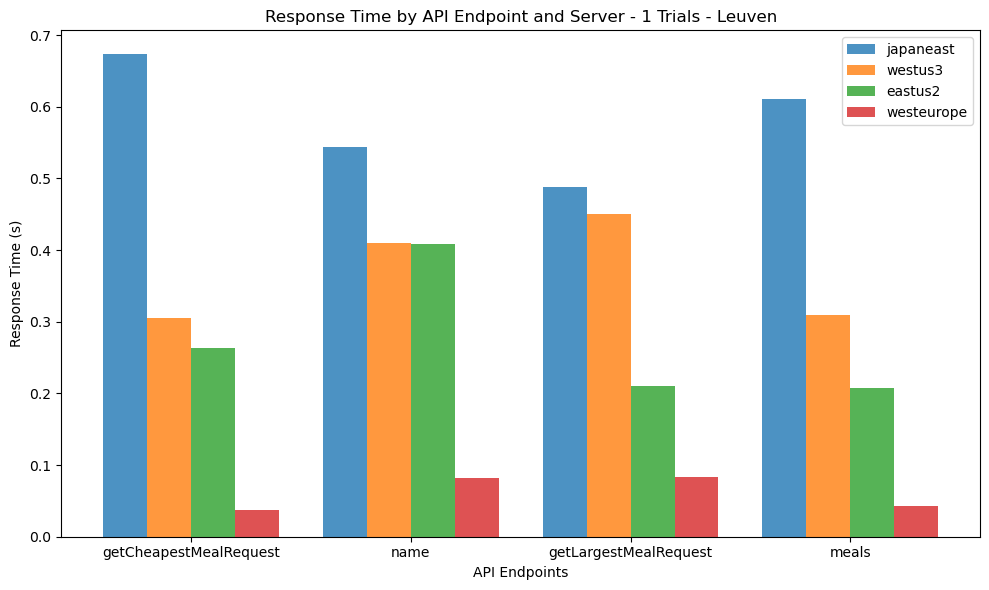

In [51]:
plot_data(soap_response_times_dict, num_requests, this_ip, server_list, extra_title=None);

## Analysing Data from the Servers